In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [4]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [5]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          635 non-null    object 
 1   Daily Confirmed                               635 non-null    int64  
 2   False Positives Found                         526 non-null    float64
 3   Cumulative Confirmed                          635 non-null    int64  
 4   Daily Discharged                              635 non-null    int64  
 5   Passed but not due to COVID                   635 non-null    int64  
 6   Cumulative Discharged                         635 non-null    int64  
 7   Discharged to Isolation                       635 non-null    int64  
 8   Still Hospitalised                            635 non-null    int64  
 9   Daily Deaths                                  635 non-null    int

In [7]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [8]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [9]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [10]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [11]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [12]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [13]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               635 non-null    int64  
 1   False Positives Found                         635 non-null    float64
 2   Cumulative Confirmed                          635 non-null    int64  
 3   Daily Discharged                              635 non-null    int64  
 4   Passed but not due to COVID                   635 non-null    int64  
 5   Cumulative Discharged                         635 non-null    int64  
 6   Discharged to Isolation                       635 non-null    int64  
 7   Still Hospitalised                            635 non-null    int64  
 8   Daily Deaths                                  635 non-null    int64  
 9   Cumulative Deaths                             635 non-null    int

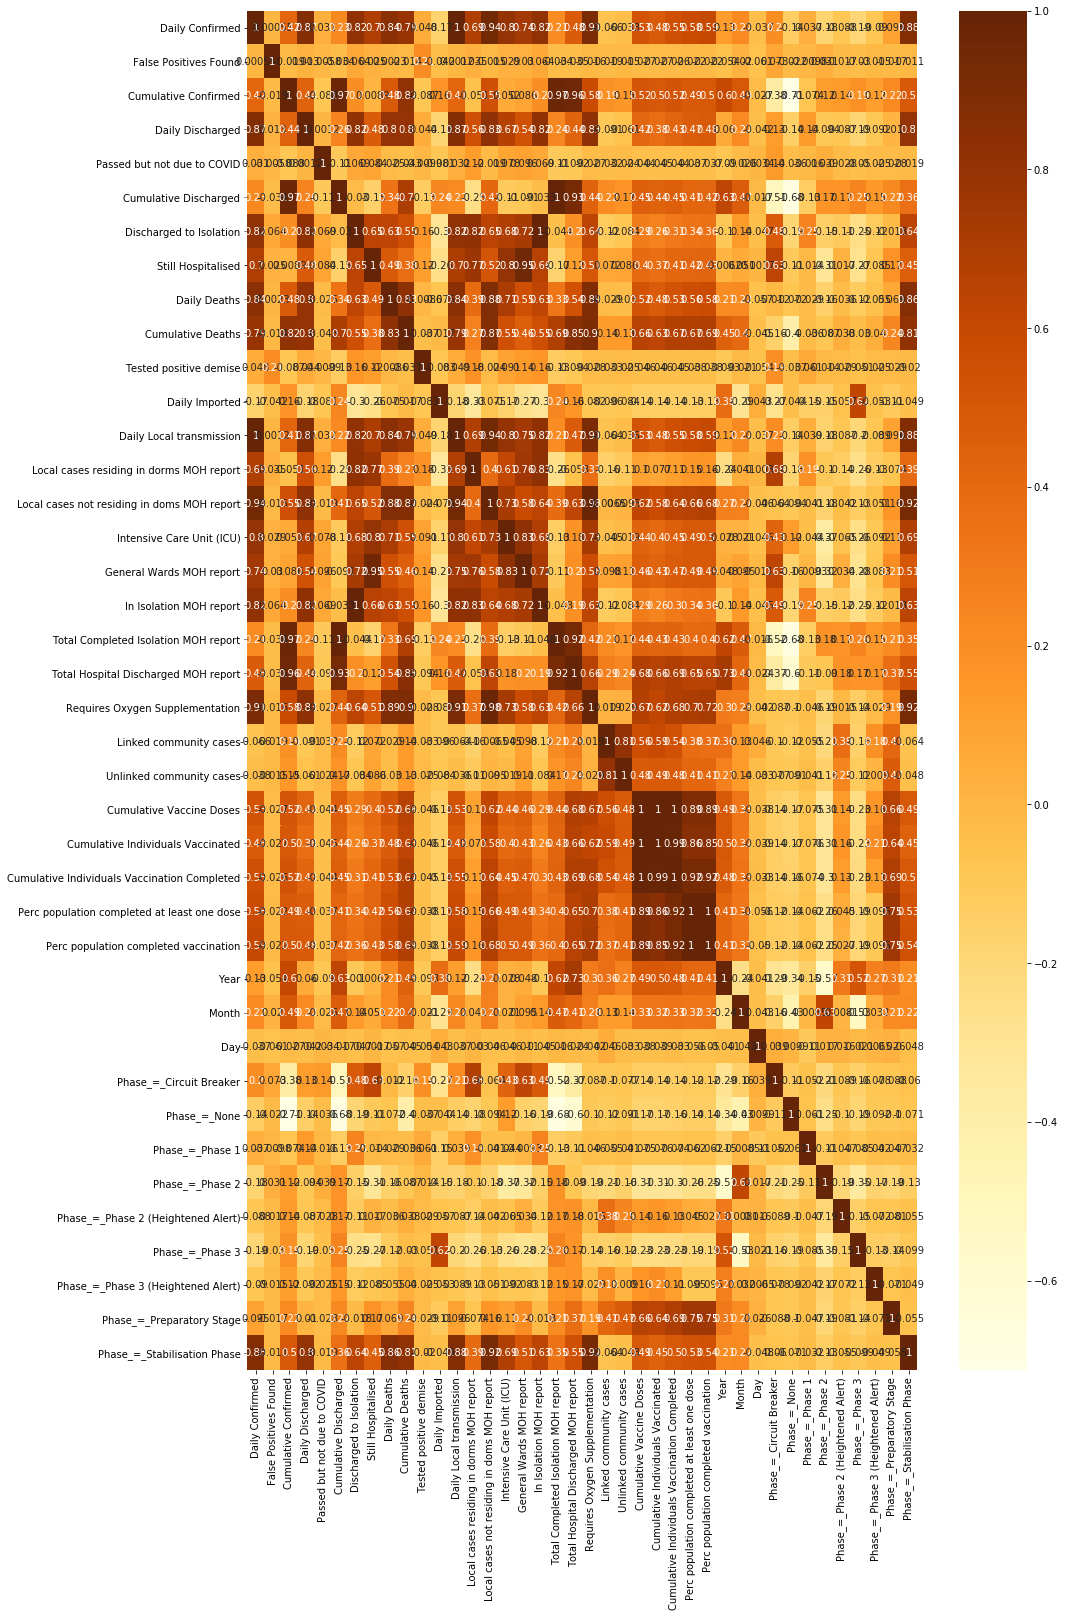

In [14]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [15]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Intensive Care Unit (ICU)"].sort_values(ascending=False)

Intensive Care Unit (ICU)                       1.000000
General Wards MOH report                        0.832657
Daily Local transmission                        0.804767
Daily Confirmed                                 0.804279
Still Hospitalised                              0.800936
Requires Oxygen Supplementation                 0.732267
Local cases not residing in doms MOH report     0.725705
Daily Deaths                                    0.705809
Phase_=_Stabilisation Phase                     0.688269
In Isolation MOH report                         0.684254
Discharged to Isolation                         0.681137
Daily Discharged                                0.666781
Local cases residing in dorms MOH report        0.613133
Cumulative Deaths                               0.547071
Perc population completed vaccination           0.503390
Perc population completed at least one dose     0.492092
Cumulative Individuals Vaccination Completed    0.451639
Cumulative Vaccine Doses       

In [16]:
# remove cols with correlation score >0.7
new_sg_data_filtered=sg_data_filtered.drop(["General Wards MOH report","Daily Local transmission",
                                            "Daily Confirmed","Still Hospitalised","Requires Oxygen Supplementation",
                                             "Local cases not residing in doms MOH report","Daily Deaths"], axis=1)

In [17]:
# check correlation after removing
new_sg_data_filtered.corr()["Intensive Care Unit (ICU)"].sort_values(ascending=False)

Intensive Care Unit (ICU)                       1.000000
Phase_=_Stabilisation Phase                     0.688269
In Isolation MOH report                         0.684254
Discharged to Isolation                         0.681137
Daily Discharged                                0.666781
Local cases residing in dorms MOH report        0.613133
Cumulative Deaths                               0.547071
Perc population completed vaccination           0.503390
Perc population completed at least one dose     0.492092
Cumulative Individuals Vaccination Completed    0.451639
Cumulative Vaccine Doses                        0.436959
Phase_=_Circuit Breaker                         0.434042
Cumulative Individuals Vaccinated               0.398694
Total Hospital Discharged MOH report            0.179572
Phase_=_None                                    0.124888
Phase_=_Preparatory Stage                       0.107990
Tested positive demise                          0.090537
Passed but not due to COVID    

# Train Test Split

In [18]:
# change y variable accordingly to what is of interest

X = new_sg_data_filtered.drop("Intensive Care Unit (ICU)", axis=1)
y = new_sg_data_filtered["Intensive Care Unit (ICU)"]

In [19]:
# split using 20% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Linear Regression

In [20]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [21]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y)), 4)}")

Evaluation Metrics for LR
MAE: 2.1750410843778165
MSE: 10.895137429224409
RMSE: 3.3007783065853435
R-squared score for train: 0.9286116738497575
Adjusted R-squared score for train: 0.9248169455494125
R-squared score for test: 0.9115177618395162
Adjusted R-squared score for test: 0.9068143870535769
Cross Validation Score: -336.9116


C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


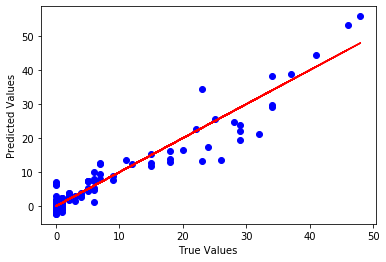

In [22]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

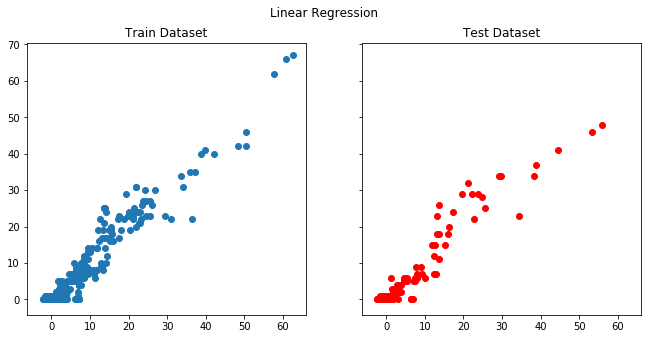

In [23]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [24]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
18,Perc population completed at least one dose,101.139640
23,Phase_=_Circuit Breaker,3.666299
20,Year,2.269891
30,Phase_=_Preparatory Stage,1.596238
31,Phase_=_Stabilisation Phase,0.663899
3,Passed but not due to COVID,0.649377
21,Month,0.424946
6,Cumulative Deaths,0.187982
8,Daily Imported,0.097854
0,False Positives Found,0.034016


# Ridge Regression

In [25]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.39514e-17): result may not be accurate.
  overwrite_a=True).T


In [26]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")

Evaluation Metrics for Ridge
MAE: 2.226676311284691
MSE: 11.681417592265003
RMSE: 3.4178088876157195
R-squared score for train: 0.9257754268473534
Adjusted R-squared score for train: 0.9218299345867476
R-squared score for test: 0.9051321766095027
Adjusted R-squared score for test: 0.9000893687216358
Cross Validation Score: -23.9155


C:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.80902e-17): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.92687e-17): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.45365e-17): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.40157e-17): result may not be accurate.
  overwrite_a=True).T


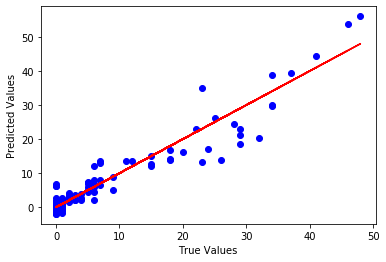

In [27]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

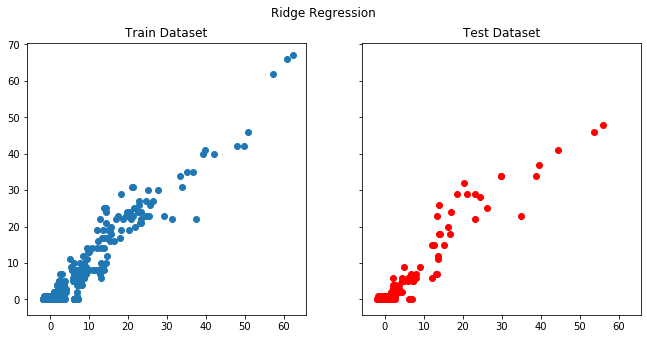

In [28]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [29]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
23,Phase_=_Circuit Breaker,3.463203
20,Year,3.324615
18,Perc population completed at least one dose,1.318709
21,Month,0.520624
3,Passed but not due to COVID,0.508152
6,Cumulative Deaths,0.219364
27,Phase_=_Phase 2 (Heightened Alert),0.213262
26,Phase_=_Phase 2,0.154851
8,Daily Imported,0.093601
31,Phase_=_Stabilisation Phase,0.086669
